# Problem Scope Definition

The objective of this investigation is to identify the factors that contribute to user adoption, where an adopted user is defined as a user that has logged into the product on three separate days within at least one seven day period. The data source is limited to the 12,000 users that have signed up in the past two years and the usage summary table.

# Planning

This investigation could be interpreted as a classification problem in trying to determine if a user will adopt or not. The emphasis is on the features, so the model should be interpretable in terms of being able to understand feature importance.

# Loading Data

In [1]:
import pandas as pd
import bamboolib
import missingno as msno
import lightgbm
from bayes_opt import BayesianOptimization
import numpy as np
from sklearn.model_selection import train_test_split
import datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from skopt import BayesSearchCV

# Users Table

This table has a record of 12,000 users that have signed up in the past two years. The features are:

* name:  the  user's  name
* object_id:   the  user's  id
* email:  email  address
* creation_source:   how  their  account  was  created.  This  takes  on  one
of  5  values:
     * PERSONAL_PROJECTS:  invited  to  join  another  user's
personal  workspace
     * GUEST_INVITE:  invited  to  an  organization  as  a  guest
(limited  permissions)
     * ORG_INVITE:  invited  to  an  organization  (as  a  full  member)
     * SIGNUP:  signed  up  via  the  website
     * SIGNUP_GOOGLE_AUTH:  signed  up  using  Google
Authentication  (using  a  Google  email  account  for  their  login
id)
* creation_time:  when  they  created  their  account
* last_session_creation_time:   unix  timestamp  of  last  login
* opted_in_to_mailing_list:  whether  they  have  opted  into  receiving
marketing  emails
* enabled_for_marketing_drip:  whether  they  are  on  the  regular
marketing  email  drip
* org_id:   the  organization  (group  of  users)  they  belong  to
* invited_by_user_id:   which  user  invited  them  to  join  (if  applicable).

In [2]:
users = pd.read_csv('takehome_users.csv', encoding = 'latin1')

In [3]:
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


# Missing Users Data

The following table shows that approximately 47% of observations are missing a invited_by_user_id (suggesting that they were not recommended the platform by another user) and about 27% missing are missing a last_session_creation_time (suggesting that they never logged in for the first time).

In [4]:
missing = pd.concat([users.isnull().sum().sort_values(ascending = False), 100 * users.isnull().mean().sort_values(ascending = False)], axis=1)
missing.columns=['count', '%']
print(missing)

                            count       %
invited_by_user_id           5583  46.525
last_session_creation_time   3177  26.475
object_id                       0   0.000
creation_time                   0   0.000
name                            0   0.000
email                           0   0.000
creation_source                 0   0.000
opted_in_to_mailing_list        0   0.000
enabled_for_marketing_drip      0   0.000
org_id                          0   0.000


The missingness matrix suggests that these observations are missing completely at random.

<AxesSubplot:>

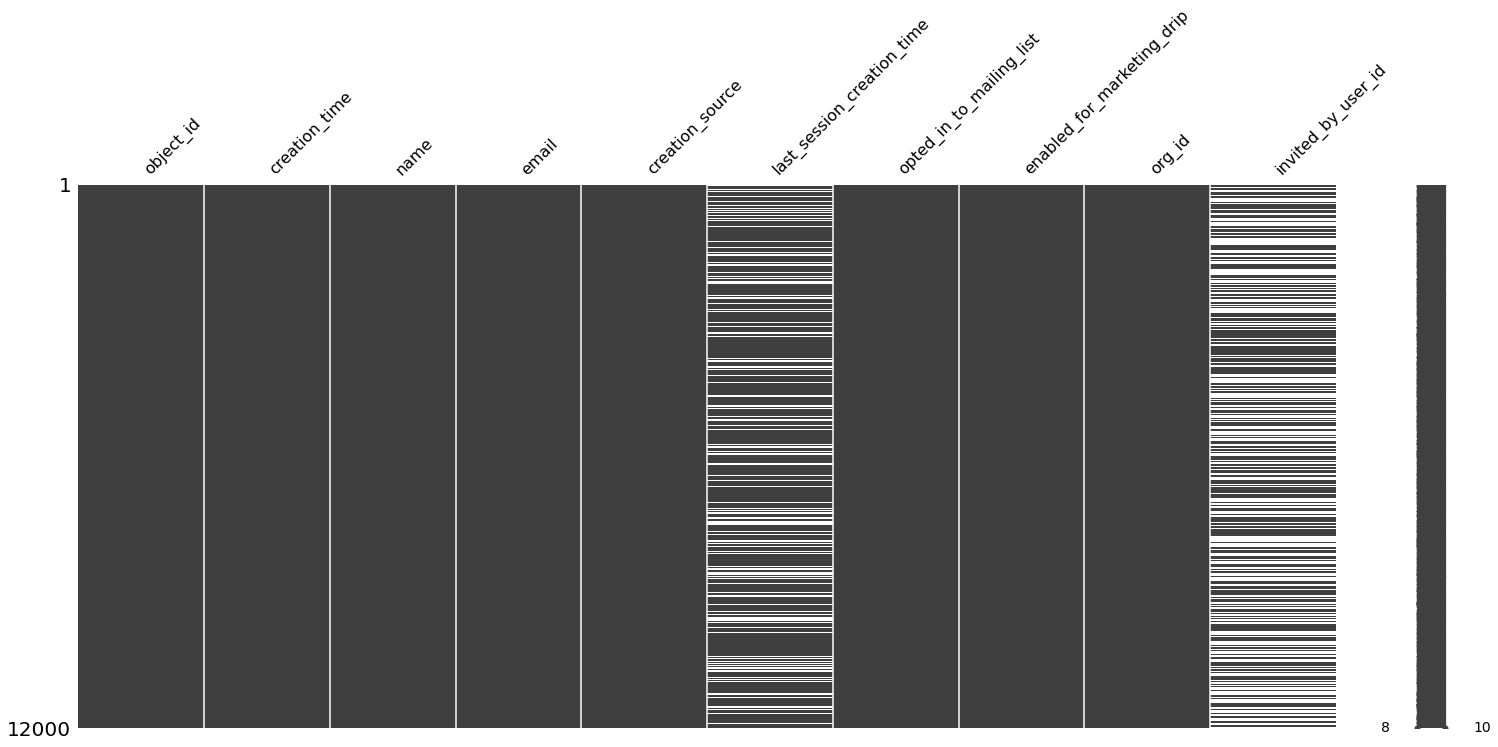

In [5]:
msno.matrix(users)

# Duplicate User Data

There are no duplicated records for users

In [6]:
print(users[users.duplicated() == True])

Empty DataFrame
Columns: [object_id, creation_time, name, email, creation_source, last_session_creation_time, opted_in_to_mailing_list, enabled_for_marketing_drip, org_id, invited_by_user_id]
Index: []


# User Engagement Table

This table records the timestamps of user logins. It is not missing any data. There are also no duplicates.

In [7]:
user_engagement = pd.read_csv('takehome_user_engagement.csv')

In [8]:
user_engagement['time_stamp'] = pd.to_datetime(user_engagement['time_stamp'], infer_datetime_format=True)
user_engagement

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [9]:
missing = pd.concat([user_engagement.isnull().sum().sort_values(ascending = False), 100 * user_engagement.isnull().mean().sort_values(ascending = False)], axis=1)
missing.columns=['count', '%']
print(missing)

            count    %
time_stamp      0  0.0
user_id         0  0.0
visited         0  0.0


In [10]:
print(user_engagement[user_engagement.duplicated() == True])

Empty DataFrame
Columns: [time_stamp, user_id, visited]
Index: []


# Feature Engineering

The primary feature of interest (adopted user class) does not exist in the original data, so it must be engineered from the two datasets.

The scope defines an adopted user as an individual who has logged in for at least 3 separate days in at least one 7 day period. More generally, I chose to define an adopted user as an individual whose login count to time delta ratio is greater than or equal to 3 /7 = 0.4286. Doing so identifies 424 adopted users.

In [11]:
def get_rolling_count(grp, freq):
    return grp.rolling(freq, on='time_stamp')['user_id'].count()

In [12]:
user_engagement['visits_rolling_7'] = user_engagement.groupby('user_id', as_index=False, group_keys=False).apply(get_rolling_count, '7D')
user_engagement

,time_stamp,user_id,visited,visits_rolling_7
0,2014-04-22 03:53:30,1,1,1.0
1,2013-11-15 03:45:04,2,1,1.0
2,2013-11-29 03:45:04,2,1,1.0
3,2013-12-09 03:45:04,2,1,1.0
4,2013-12-25 03:45:04,2,1,1.0
...,...,...,...,...
207912,2013-09-06 06:14:15,11996,1,1.0
207913,2013-01-15 18:28:37,11997,1,1.0
207914,2014-04-27 12:45:16,11998,1,1.0
207915,2012-06-02 11:55:59,11999,1,1.0


In [13]:
adopted_users = user_engagement.groupby(['user_id']).agg(visits_rolling_7_max=('visits_rolling_7', 'max')).reset_index()
adopted_users = adopted_users.loc[adopted_users['visits_rolling_7_max'] >= 3]
adopted_users

,user_id,visits_rolling_7_max
1,2,3.0
7,10,7.0
13,20,3.0
24,33,3.0
28,42,7.0
...,...,...
8797,11965,4.0
8798,11967,7.0
8800,11969,7.0
8802,11975,7.0


In [14]:
users['adopted_user'] = 0

In [15]:
users.loc[users.object_id.isin(adopted_users.user_id)] = 1

# Invited By User

It's probably not important to know who referred who, but rather whether someone was referred or not, so this feature was changed to a binary variable.

In [16]:
users['invited_by_user_id'] = users['invited_by_user_id'].replace(np.nan, 0)
users.loc[users['invited_by_user_id'] != 0, 'invited_by_user_id'] = 1
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,1.0,0
1,1,1,1,1,1,1.000000e+00,1,1,1,1.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,1.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,1.0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,0.0,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,1.0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,0.0,0


# Creation Time

The creation time was turned into an integer value represented the days elapsed since account creation.

In [17]:
users['creation_time'] = pd.to_datetime(users['creation_time'], infer_datetime_format=True)
users['creation_time'] = datetime.datetime.now() - users['creation_time']
users['creation_time'] = users['creation_time'].dt.days
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2847,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,1.0,0
1,1,19029,1,1,1,1.000000e+00,1,1,1,1.0,1
2,3,3245,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1.0,0
3,4,3183,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,1.0,0
4,5,3307,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,3075,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,1.0,0
11996,11997,3313,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,0.0,0
11997,11998,2841,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,1.0,0
11998,11999,3537,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,0.0,0


# Last Session Creation Time

The observations with no last session creation time recorded were dropped.

In [18]:
users = users.dropna(subset=['last_session_creation_time'])
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2847,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,1.0,0
1,1,19029,1,1,1,1.000000e+00,1,1,1,1.0,1
2,3,3245,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1.0,0
3,4,3183,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,1.0,0
4,5,3307,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,3075,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,1.0,0
11996,11997,3313,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,0.0,0
11997,11998,2841,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,1.0,0
11998,11999,3537,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,0.0,0


# One Hot Encoding

I dropped the name and email features and one hot encoded the remaining categorical features.

In [19]:
users = users.drop(columns=['name', 'email'])
users = pd.get_dummies(users, columns=['creation_source'], drop_first=True)
users

,object_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,2847,1.398139e+09,1,0,11,1.0,0,1,0,0,0,0
1,1,19029,1.000000e+00,1,1,1,1.0,1,0,0,0,0,0
2,3,3245,1.363735e+09,0,0,94,1.0,0,0,1,0,0,0
3,4,3183,1.369210e+09,0,0,1,1.0,0,1,0,0,0,0
4,5,3307,1.358850e+09,0,0,193,1.0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,3075,1.378448e+09,0,0,89,1.0,0,0,1,0,0,0
11996,11997,3313,1.358275e+09,0,0,200,0.0,0,0,0,0,0,1
11997,11998,2841,1.398603e+09,1,1,83,1.0,0,1,0,0,0,0
11998,11999,3537,1.338638e+09,0,0,6,0.0,0,0,0,1,0,0


# Train Test Split

I want to evaluate the predictive power of the features, so the data will be split for evaluating the performance of the model.

In [20]:
X = users.drop(columns = ['adopted_user', 'object_id'])
y = users['adopted_user']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

# Gradient Boosting Classifier

For the purposes of this investigation I chose to use a gradient boosting classifier to find the feature importance for different features. The testing results suggest that the model is overfitted, but it still provides useful insights into the reltive importance of the features.

In [22]:
param_grid = dict(
    learning_rate=[0.001, 0.05, 0.1, 0.2, 0.5],
    max_depth=list(range(2,4)),
    min_samples_leaf=list(range(1,21)),
    min_samples_split=list(range(5,51)),
)
gb = GradientBoostingClassifier(n_estimators=50, max_features=2, 
                                random_state = 42)
gb_cv = BayesSearchCV(gb, param_grid, scoring='f1', cv=5, n_iter = 32)
gb_cv.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=GradientBoostingClassifier(max_features=2,
                                                   n_estimators=50,
                                                   random_state=42),
              n_iter=32, scoring='f1',
              search_spaces={'learning_rate': [0.001, 0.05, 0.1, 0.2, 0.5],
                             'max_depth': [2, 3],
                             'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                  11, 12, 13, 14, 15, 16, 17,
                                                  18, 19, 20],
                             'min_samples_split': [5, 6, 7, 8, 9, 10, 11, 12,
                                                   13, 14, 15, 16, 17, 18, 19,
                                                   20, 21, 22, 23, 24, 25, 26,
                                                   27, 28, 29, 30, 31, 32, 33,
                                                   34, ...]})

In [23]:
gb_cv.best_params_

OrderedDict([('learning_rate', 0.05),
             ('max_depth', 3),
             ('min_samples_leaf', 8),
             ('min_samples_split', 19)])

In [24]:
y_pred = gb_cv.predict(X_train)

In [25]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5794
           1       1.00      1.00      1.00      1264

    accuracy                           1.00      7058
   macro avg       1.00      1.00      1.00      7058
weighted avg       1.00      1.00      1.00      7058



In [26]:
y_pred = gb_cv.predict(X_test)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1427
           1       1.00      1.00      1.00       338

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



In [28]:
gb = GradientBoostingClassifier(n_estimators=50, max_features=2, learning_rate = 0.5,
                                random_state = 42, min_samples_split = 38, min_samples_leaf = 19, max_depth = 3).fit(X_train, y_train)

# Summary

The following is a list of the features available and their relative importance based on the Gradient Boosting Classifier. Logically, individuals who received marketing content and who were referred to by specific organizations were more likely to adopt.

In [29]:
sorted(list(zip(gb.feature_importances_, X_train.columns)), reverse = True)

[(0.4399492210744821, 'enabled_for_marketing_drip'),
 (0.40321371685523655, 'org_id'),
 (0.09685681167738923, 'creation_time'),
 (0.03865507251363368, 'opted_in_to_mailing_list'),
 (0.009574875529371342, 'creation_source_ORG_INVITE'),
 (0.007770180520615839, 'creation_source_GUEST_INVITE'),
 (0.003912827805800258, 'invited_by_user_id'),
 (3.486748023611498e-05, 'creation_source_SIGNUP'),
 (2.8263838348043618e-05, 'last_session_creation_time'),
 (4.161298167261084e-06, 'creation_source_PERSONAL_PROJECTS'),
 (1.4067195047166528e-09, 'creation_source_SIGNUP_GOOGLE_AUTH')]